# Analysis of Siren based trained models vs JPEG

### Fetch Libs, data

In [1]:
# Import libs for running notebook.

from utils.libs import *

In [2]:
# Read config file for runnig notebook.

conf_file_path = 'conf.txt'
conf_data = read_conf_file(conf_file_path)

# pprint(conf_data)

In [3]:
# Fetch data about carryed out trainings.
train_df, _, _ = fetch_data(conf_data)

SELECT image,date,timestamp,hidden_features,image_size,status FROM table_runs_logged WHERE image_size = "[256,256]";
Counter({10.0: 9, 11.0: 9, 12.0: 9, 13.0: 9, 3.0: 6, 4.0: 6, 5.0: 6, 6.0: 6, 7.0: 6, 8.0: 6, 9.0: 6})


In [4]:
# np.unique(pd.DataFrame(data = list(map(operator.methodcaller('_asdict'), records_list)))['image_size'].values)

In [5]:
train_df.head(5)

,#params,seed,hl,hf,mse,psnr,ssim,eta
1603478755-305517,57301.0,0.0,10.0,75.0,0.000006,58.145780,0.998769,2688.703879
1603478755-305517,57301.0,42.0,10.0,75.0,0.000009,56.492704,0.998202,2690.827056
1603478755-305517,57301.0,123.0,10.0,75.0,0.000006,58.214385,0.999085,2686.608420
1603478755-305517,63001.0,0.0,11.0,75.0,0.000018,53.486111,0.997542,2904.513145
1603478755-305517,63001.0,42.0,11.0,75.0,0.000005,58.401365,0.999003,2906.302068


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 1603478755-305517 to 1603731938-952001
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #params  78 non-null     float64
 1   seed     78 non-null     float64
 2   hl       78 non-null     float64
 3   hf       78 non-null     float64
 4   mse      78 non-null     float64
 5   psnr     78 non-null     float64
 6   ssim     78 non-null     float64
 7   eta      78 non-null     float64
dtypes: float64(8)
memory usage: 5.5+ KB


In [7]:
train_df.describe()

,#params,seed,hl,hf,mse,psnr,ssim,eta
count,78.000000,78.000000,78.000000,78.000000,7.800000e+01,78.000000,78.000000,78.000000
mean,45534.846154,55.000000,8.538462,70.769231,5.972473e-05,52.091469,0.995068,2153.865017
std,24477.504023,51.379414,3.222052,14.005493,8.962404e-05,6.014293,0.006785,750.845186
min,9461.000000,0.000000,3.000000,55.000000,9.706207e-07,39.305184,0.959150,913.606552
25%,24861.000000,0.000000,6.000000,55.000000,8.742846e-06,47.419619,0.994080,1496.197473
50%,38721.000000,42.000000,9.000000,75.000000,2.203887e-05,52.510551,0.997342,2087.958141
75%,66131.000000,123.000000,11.000000,85.000000,6.684065e-05,56.782967,0.998887,2809.936580
max,95371.000000,123.000000,13.000000,85.000000,4.519178e-04,65.722240,0.999817,3499.902338


### Calculate Jpge

Image size: (512, 512)


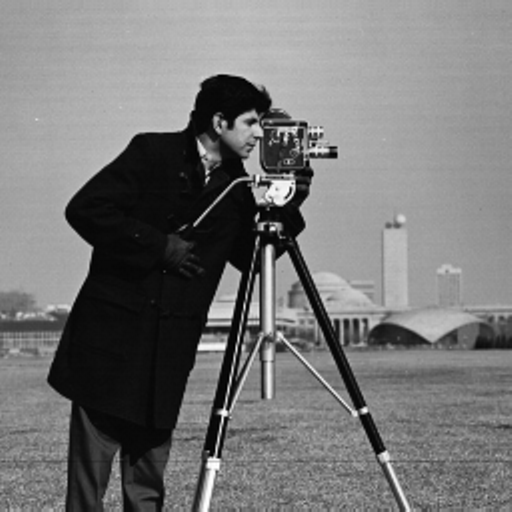

In [8]:
# Load target image.
im = load_target_image(image_file_path = None)
print('Image size:', im.size)
im

In [9]:
crop_size = conf_data['cropped_image']['crop_size']
if isinstance(crop_size, str):
    crop_size = eval(crop_size)
elif isinstance(crop_size, int):
    crop_size = (crop_size, crop_size)
    pass
# type(crop_size[0])

Image size: (256, 256)


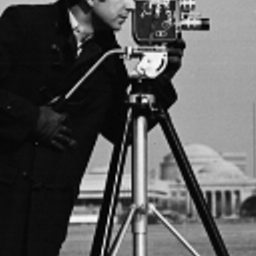

In [10]:
if conf_data['cropped_image']['flag'] is True:
    im_cropped = get_cropped_by_center_image(im, target = crop_size)
    pass
else:
    im_cropped = im
print('Image size:', im_cropped.size)
im_cropped

In [11]:
# Array of qualities to be tested in compression.
qualities_arr = np.arange(20, 95+1, dtype = np.int)

In [12]:
# Run several trials for JPEG compression.

cropped_file_size_bits = None

# im_cropped = im
# im_cropped = Image.fromarray(skimage.data.camera())
with BytesIO() as f:
    im_cropped.save(f, format='PNG')
    cropped_file_size_bits = f.getbuffer().nbytes * 8
    pass

result_tuples, failure_qualities = \
  calculate_several_jpeg_compression(im_cropped, cropped_file_size_bits, qualities_arr)

In [13]:
# data = list(map(lambda xx: xx._asdict(), result_tuples))
data = list(map(operator.methodcaller('_asdict'), result_tuples))
result_jpeg_df = pd.DataFrame(data = data)
result_jpeg_df.head(5)

,psnr,ssim,quality,file_size_bits,bpp,width,heigth,CR
0,33.270993,0.939424,20,33064,0.504517,256,256,7.682071
1,33.514350,0.940436,21,33968,0.518311,256,256,7.477626
2,33.684117,0.941620,22,34736,0.530029,256,256,7.312298
3,33.928492,0.944786,23,35408,0.540283,256,256,7.173520
4,34.115361,0.946817,24,36000,0.549316,256,256,7.055556


### Show graphics.

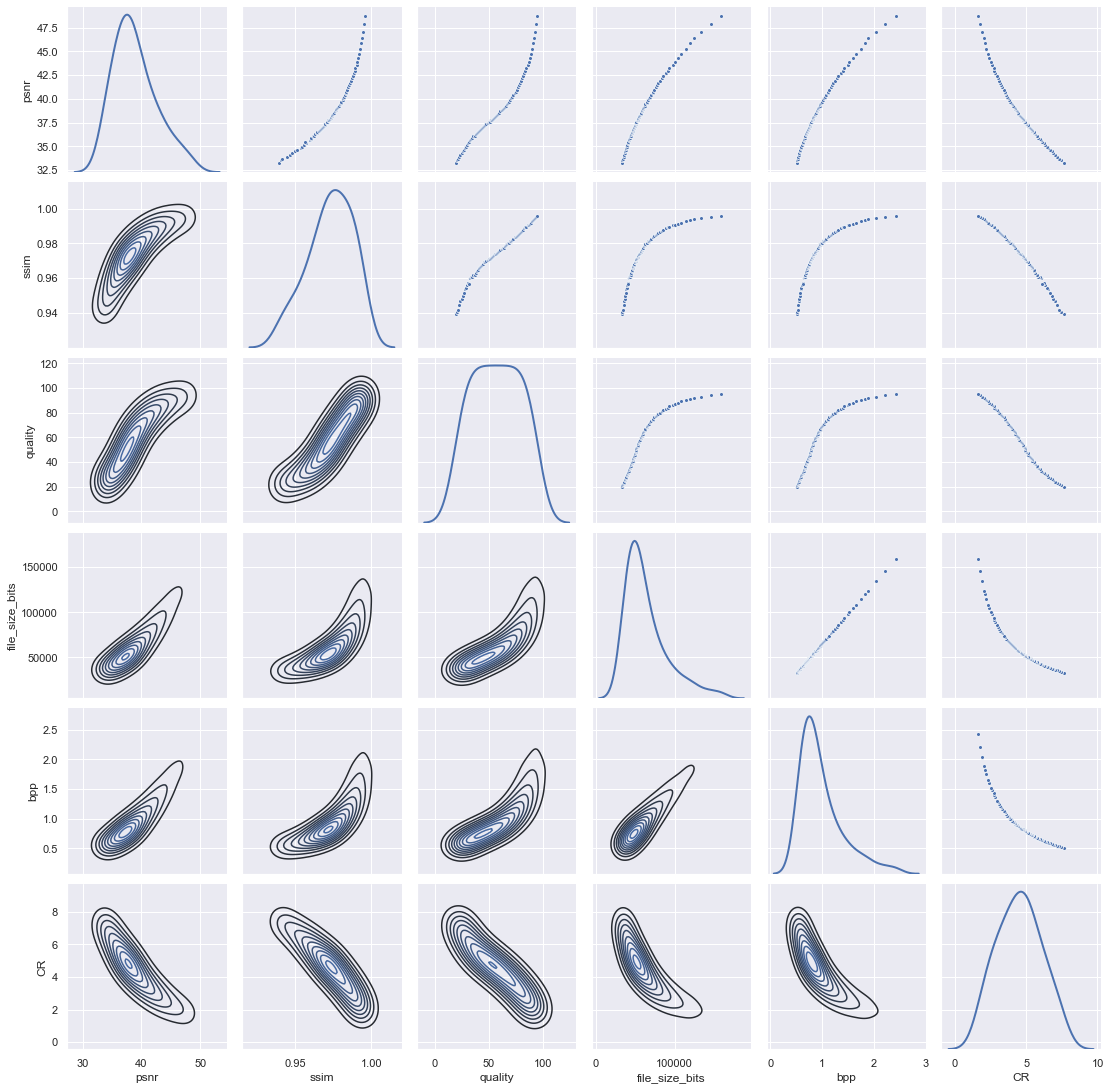

In [14]:
# sns.pairplot(results_history_df)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        g = sns.PairGrid(result_jpeg_df.drop(['width', 'heigth'], axis = 1), diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15) # 
        g.map_lower(sns.kdeplot)
        g.map_diag(sns.kdeplot, lw=2)
        # plt.savefig(f"{images_conf.df_jpeg_scatterplot}")
    except Exception as err:
        print(str(err))
        pass
    pass

In [15]:
train_df['bpp'] = train_df['#params'].values * 32 / (im_cropped.size[0] * im_cropped.size[1])

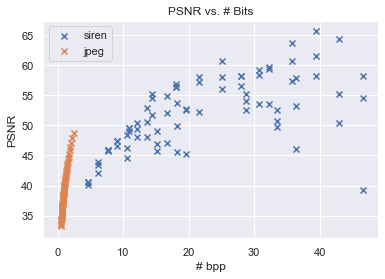

In [16]:
compare_compressions(compression_1_df=train_df, compression_2_df=result_jpeg_df)

In [17]:
result_jpeg_df.columns, train_df.columns

(Index(['psnr', 'ssim', 'quality', 'file_size_bits', 'bpp', 'width', 'heigth',
        'CR'],
       dtype='object'),
 Index(['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'eta', 'bpp'], dtype='object'))

In [18]:
type(train_df['hf'].values.astype(dtype = np.int))

numpy.ndarray

In [19]:
train_df['compression'] = list(map(lambda hf: f'siren-{hf}', train_df['hf'].values.astype(dtype = np.int)))

In [20]:
result_jpeg_df['compression'] = ['jpeg'] * result_jpeg_df.shape[0]
# train_df['compression'] = ['siren'] * train_df.shape[0]
train_df['file_size_bits'] = train_df['#params'].values * 32
train_df['CR'] = cropped_file_size_bits / train_df['#params'].values * 32

In [21]:
result_jpeg_df.columns, train_df.columns

(Index(['psnr', 'ssim', 'quality', 'file_size_bits', 'bpp', 'width', 'heigth',
        'CR', 'compression'],
       dtype='object'),
 Index(['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'eta', 'bpp',
        'compression', 'file_size_bits', 'CR'],
       dtype='object'))

In [22]:
train_df_columns_for_merge = "psnr,ssim,CR,bpp,file_size_bits,compression".split(",")
result_jpeg_df_columns_for_merge = "psnr,ssim,CR,bpp,file_size_bits,compression".split(",")

data_frames_list = [
    train_df[train_df_columns_for_merge],
    result_jpeg_df[result_jpeg_df_columns_for_merge],
]
merged_df = pd.concat(data_frames_list, names = "psnr,ssim,CR,bpp,file_size_bits,compression".split(","))

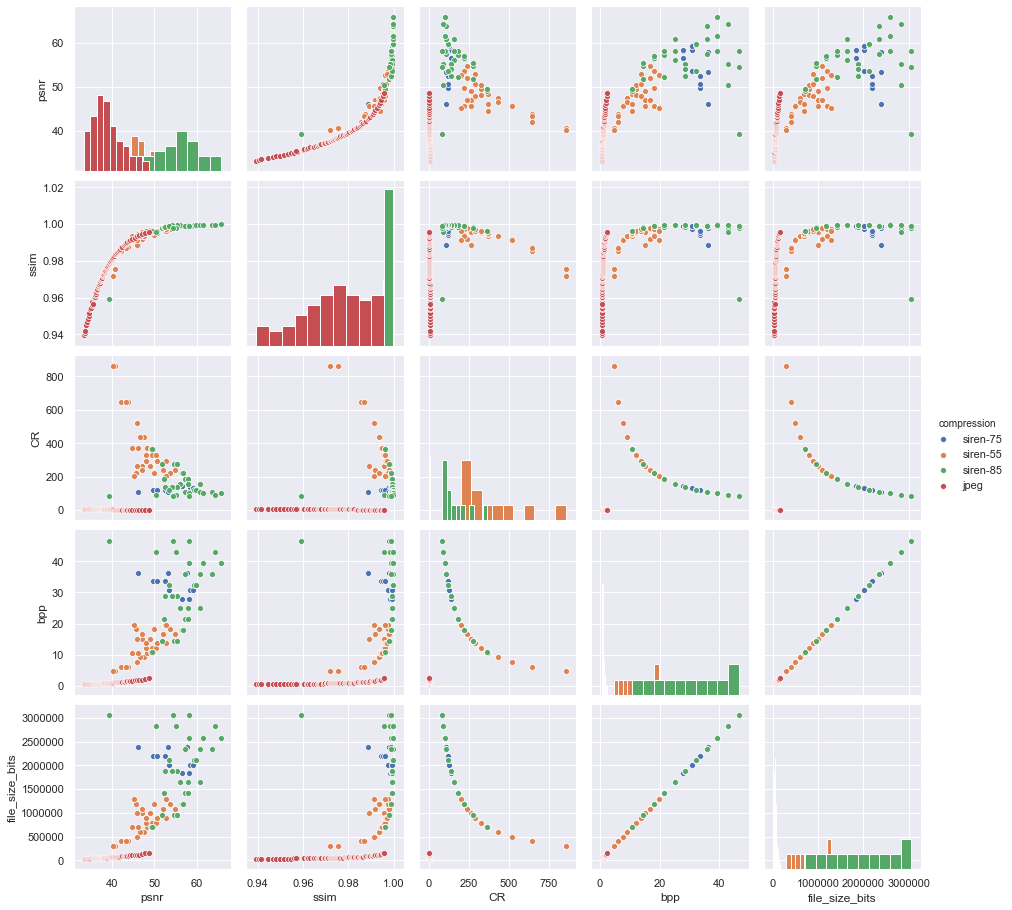

In [23]:
g = sns.PairGrid(merged_df, hue="compression")
g.map_diag(plt.hist)
g.map_offdiag(sns.scatterplot)
g.add_legend()
# g.savefig("scatter_plot_dataframes_merged.png")
plt.show()

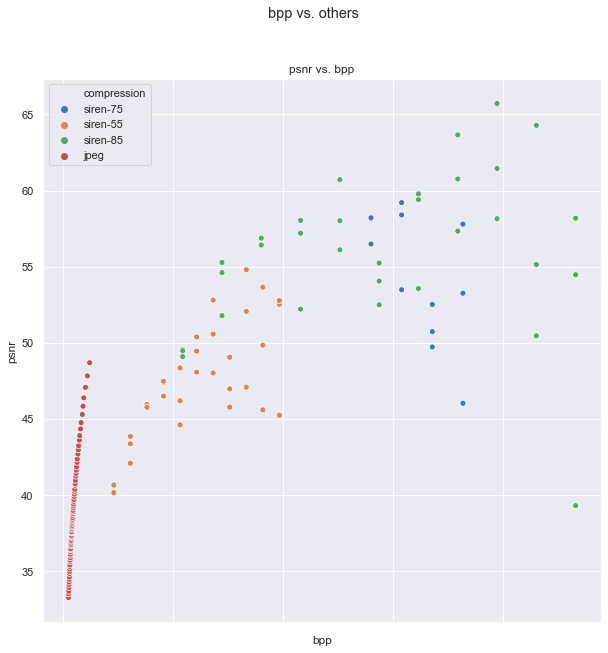

In [24]:
x = 'bpp'
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")[0:1]
y = "psnr"
hue = "compression"

fig, ax = plt.subplots(1, len(y_vars[0:1]), figsize = (10, 10))
fig.suptitle(f"{x} vs. others")


chart = sns.scatterplot(x=f"{x}", y=f"{y}", data=merged_df, ax=ax, hue='compression')
ax.set_title(f'{y} vs. {x}')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

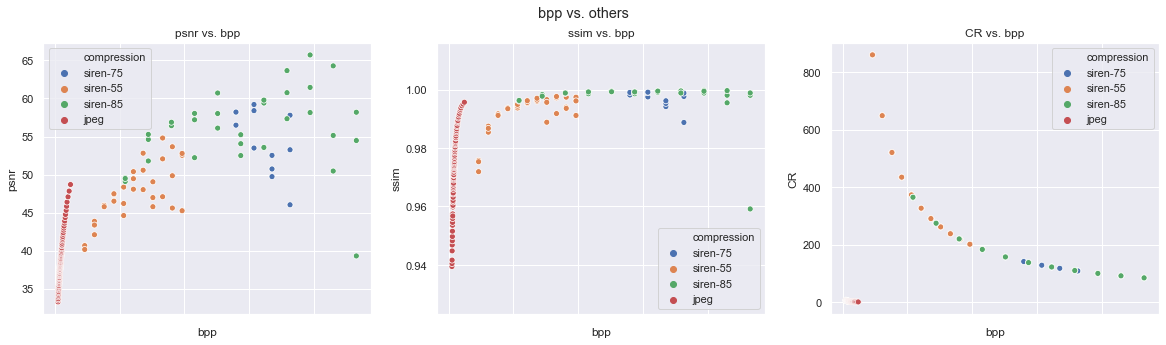

In [25]:
x = 'bpp'
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

fig, axes = plt.subplots(1, len(y_vars), figsize = (20, 5))
fig.suptitle(f"{x} vs. others")

for ax, y in zip(axes, y_vars):
    chart = sns.scatterplot(x=f"{x}", y=f"{y}", data=merged_df, ax=ax, hue='compression')
    ax.set_title(f'{y} vs. {x}')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    pass
plt.show()

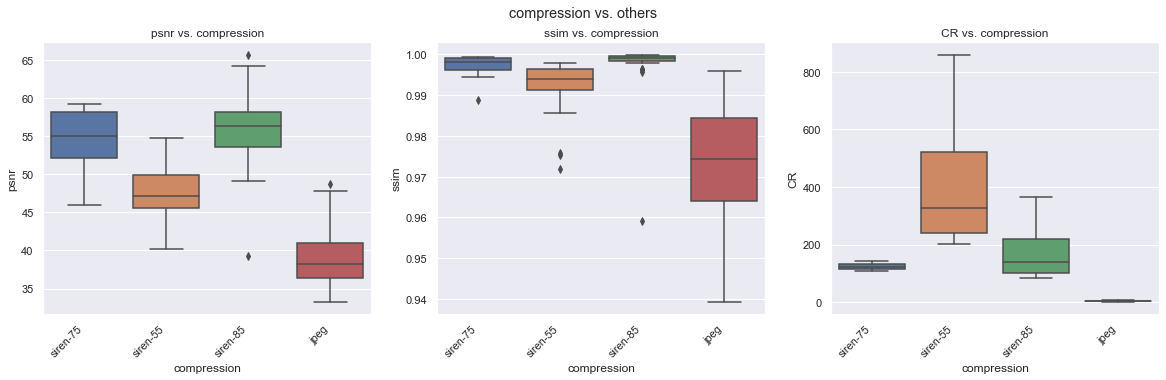

In [26]:
x = 'compression'

fig, axes = plt.subplots(1, len(y_vars), figsize = (20, 5))
fig.suptitle(f"{x} vs. others")

for ax, y in zip(axes, y_vars):
    chart = sns.boxplot(x=f"{x}", y=f"{y}", data=merged_df, ax=ax)
    ax.set_title(f'{y} vs. {x}')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    pass
plt.show()

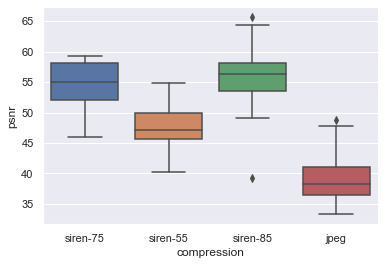

In [27]:
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

sns.boxplot(x="compression", y="psnr", data=merged_df)

plt.show()

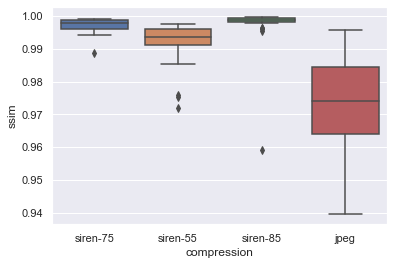

In [28]:
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

sns.boxplot(x="compression", y="ssim", data=merged_df)

plt.show()

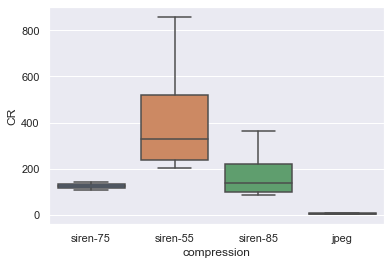

In [29]:
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

sns.boxplot(x="compression", y="CR", data=merged_df)

plt.show()

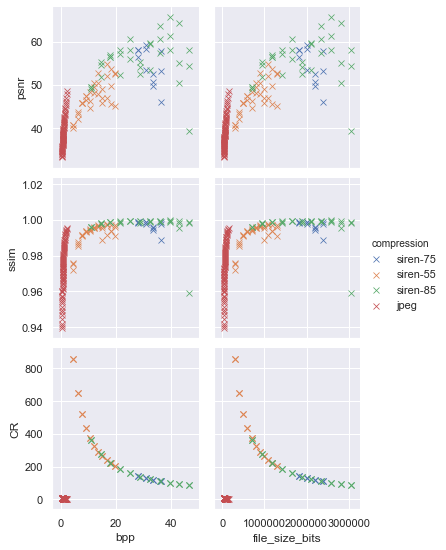

In [30]:
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

g = sns.PairGrid(merged_df, x_vars=x_vars, y_vars=y_vars, hue=hue)
g.map(sns.scatterplot, marker='x')
g.add_legend()

# g.savefig("compare_compressions_metrices.png")

plt.show()

In [31]:
x = 'file_size_bits'
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

fig.suptitle(f"{x} vs. others")

for ax, y in zip(axes, y_vars):
    chart = sns.scatterplot(x=f"{x}", y=f"{y}", data=merged_df, ax=ax, hue='compression')
    ax.set_title(f'{y} vs. {x}')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    pass
plt.show()

In [32]:
markers = ["o"] + (["x"] * (len(set(merged_df["compression"].values)) - 1))

In [33]:
# sns.__version__

In [34]:
# ?sns.jointplot

In [35]:
# sns.jointplot(data=merged_df, x="bpp", y="psnr", hue="compression")

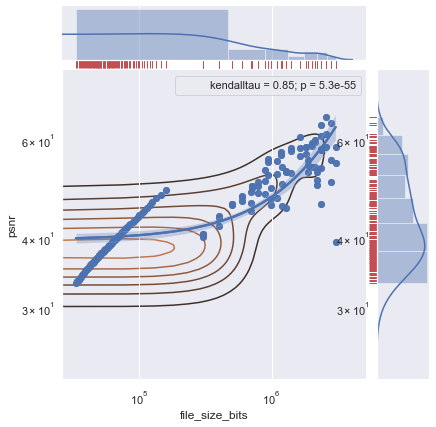

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("file_size_bits", "psnr",
            kind="reg",
            data=merged_df,
            color="b",
            # annot_kws=dict(stat="r"),
            stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

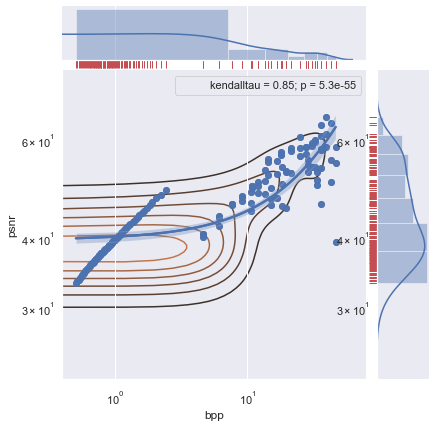

In [37]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("bpp", "psnr",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

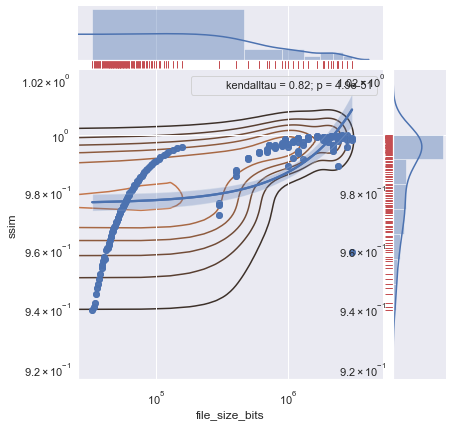

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("file_size_bits", "ssim",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

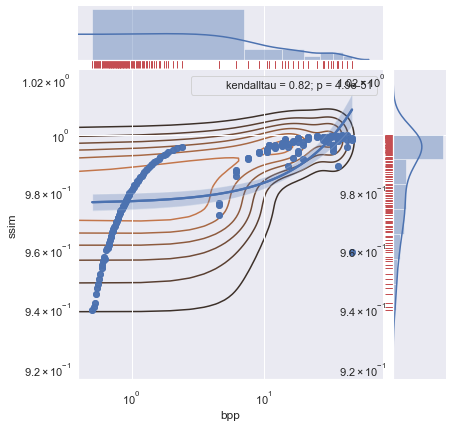

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("bpp", "ssim",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

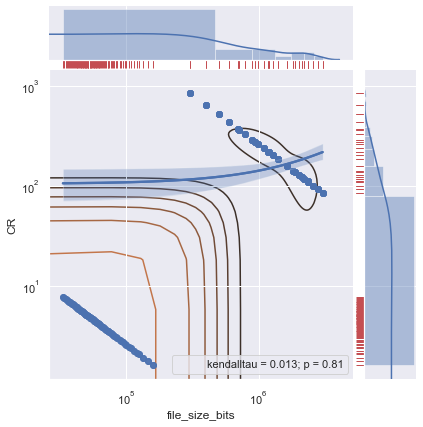

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("file_size_bits", "CR",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

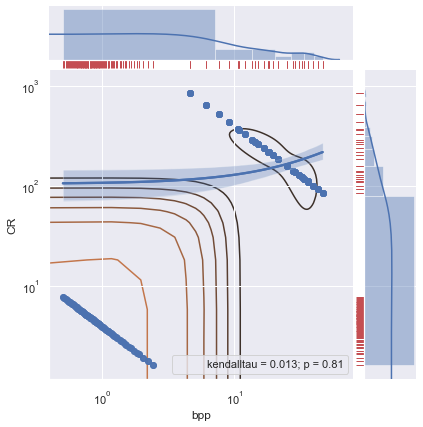

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("bpp", "CR",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

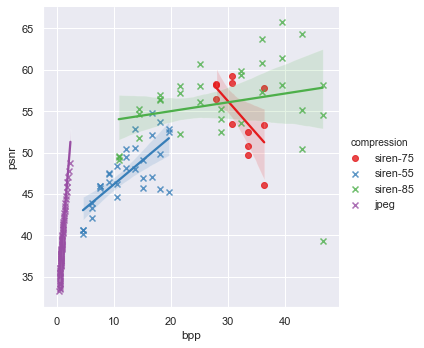

In [42]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="bpp", y="psnr", hue="compression",
    height=5,
    palette="Set1", markers=markers
).fig.subplots_adjust(wspace=.02)

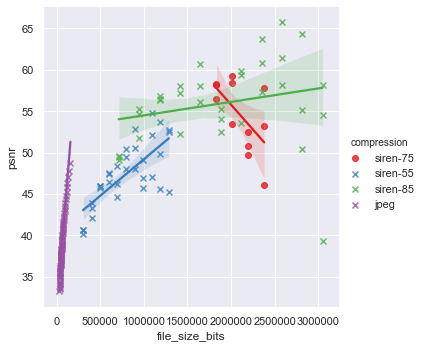

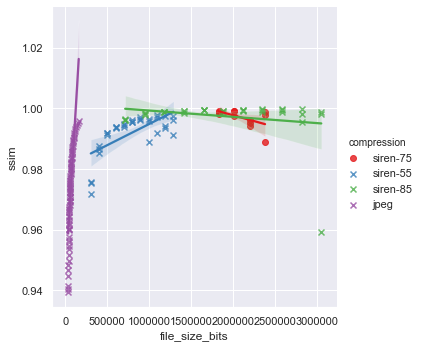

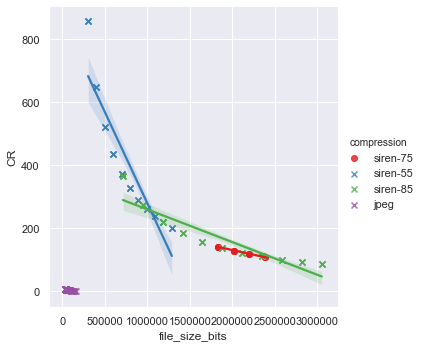

In [43]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="file_size_bits", y="psnr", hue="compression",
    height=5,
    palette="Set1", markers=markers).fig.subplots_adjust(wspace=.02)

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="file_size_bits", y="ssim", hue="compression",
    height=5,
    palette="Set1", markers=markers).fig.subplots_adjust(wspace=.02)
plt.show()

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="file_size_bits", y="CR", hue="compression",
    height=5,
    palette="Set1", markers=markers).fig.subplots_adjust(wspace=.02)
plt.show()

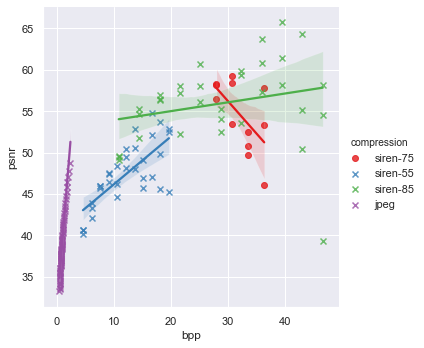

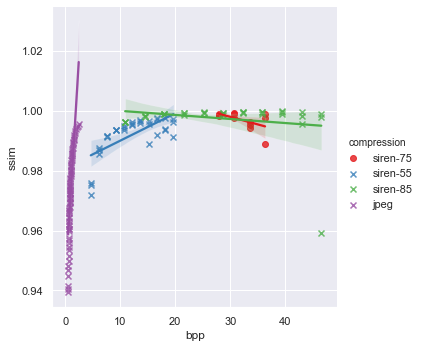

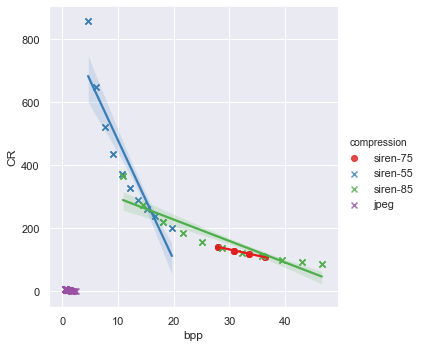

In [44]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="bpp", y="psnr", hue="compression",
    height=5,
    palette="Set1", markers=markers).fig.subplots_adjust(wspace=.02)

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="bpp", y="ssim", hue="compression",
    height=5,
    palette="Set1", markers=markers).fig.subplots_adjust(wspace=.02)
plt.show()

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=merged_df,
    x="bpp", y="CR", hue="compression",
    height=5,
    palette="Set1", markers=markers).fig.subplots_adjust(wspace=.02)
plt.show()

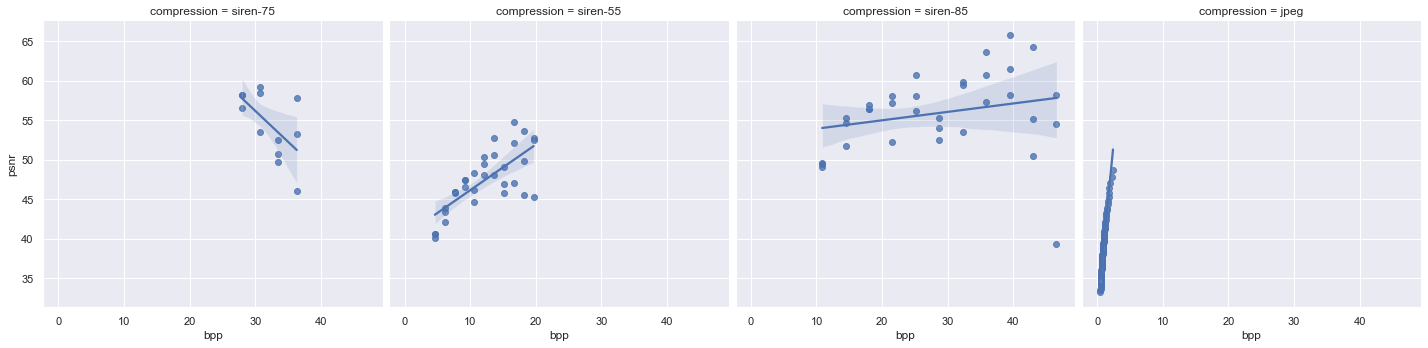

In [45]:
g = sns.lmplot(x="bpp", y="psnr", col="compression", data=merged_df, palette="Set1").fig.subplots_adjust(wspace=.02)

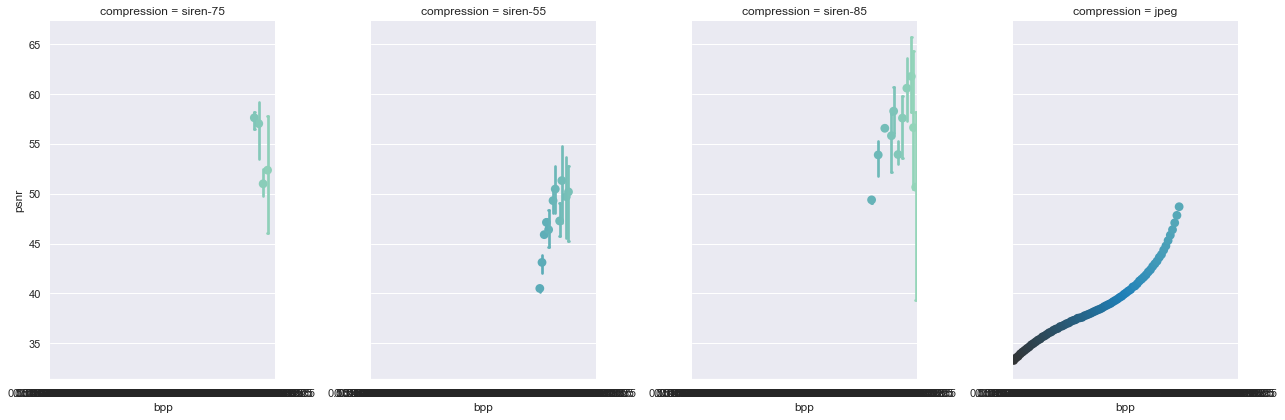

In [46]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="bpp", y="psnr", col="compression",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=merged_df)
g.despine(left=True)
plt.show()

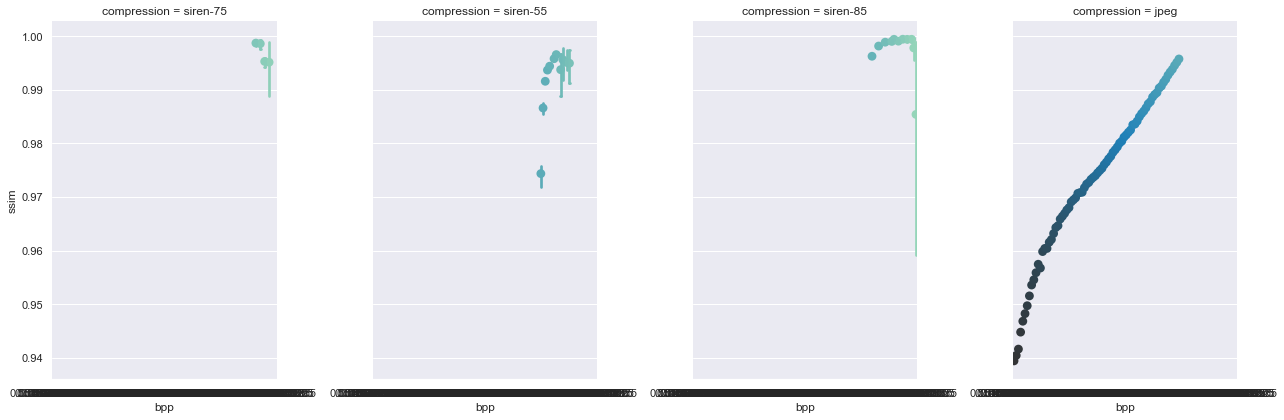

In [47]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="bpp", y="ssim", col="compression",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=merged_df)
g.despine(left=True)
plt.show()

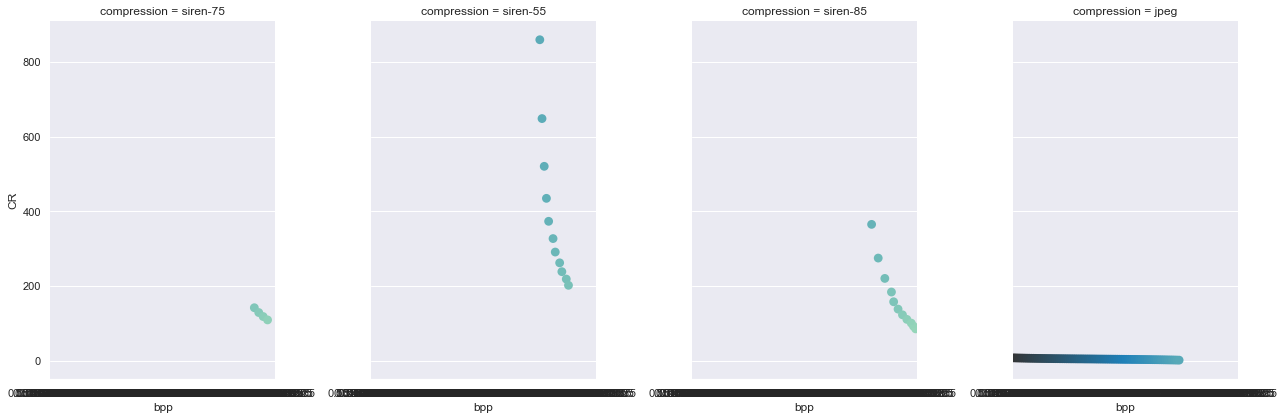

In [48]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="bpp", y="CR", col="compression",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=merged_df)
g.despine(left=True)
plt.show()

### References:
---
#### Standard Libs:
  - [Lib/statistics.py](https://docs.python.org/3/library/statistics.html)
---
#### Seaborn:
  - [seaborn.jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html?highlight=reg)
---
#### Drawing from data:
  - [drawingfromdata](https://www.drawingfromdata.com/)
  - [HOW TO ROTATE AXIS LABELS IN SEABORN AND MATPLOTLIB](https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib)